<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/Day_Trading_Tesla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip  install yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf


In [ ]:
# ✅ Download most recent 1-hour stock data (Max available: last 720 days)
df = yf.download("TSLA", period="720d", interval="1h")

# ✅ Print actual column names to check the structure
print("Original column names:", df.columns)

[*********************100%***********************]  1 of 1 completed

Original column names: MultiIndex([( 'Close', 'TSLA'),
            (  'High', 'TSLA'),
            (   'Low', 'TSLA'),
            (  'Open', 'TSLA'),
            ('Volume', 'TSLA')],
           names=['Price', 'Ticker'])


In [ ]:
# ✅ Fix Multi-Index Columns: Extract only the first level (Price Type)
df.columns = df.columns.get_level_values(0)  # Extract 'Close', 'High', 'Low', 'Open', 'Volume'

# ✅ Reset index to make "Datetime" a column
df = df.reset_index()


In [ ]:
# ✅ Keep only relevant columns
df = df[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']]

# ✅ Verify DataFrame
print(df.head())

Price                  Datetime        Open        High         Low  \
0     2022-04-04 13:30:00+00:00  363.000000  369.500000  357.510010   
1     2022-04-04 14:30:00+00:00  369.369995  378.369995  368.336700   
2     2022-04-04 15:30:00+00:00  377.830353  378.911652  375.766693   
3     2022-04-04 16:30:00+00:00  377.533356  381.463348  376.709991   
4     2022-04-04 17:30:00+00:00  381.352783  382.680023  379.833344   

Price       Close   Volume  
0      369.333344  7974058  
1      377.793335  5958949  
2      377.484619  2522470  
3      381.397430  2016766  
4      382.065826  2885778  


In [ ]:
# ✅ Reset index to make "Datetime" a column
df = df.reset_index()

# ✅ Keep only relevant columns
df = df[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']]

# ✅ Verify DataFrame
print(df.head())

Price                  Datetime        Open        High         Low  \
0     2022-04-04 13:30:00+00:00  363.000000  369.500000  357.510010   
1     2022-04-04 14:30:00+00:00  369.369995  378.369995  368.336700   
2     2022-04-04 15:30:00+00:00  377.830353  378.911652  375.766693   
3     2022-04-04 16:30:00+00:00  377.533356  381.463348  376.709991   
4     2022-04-04 17:30:00+00:00  381.352783  382.680023  379.833344   

Price       Close   Volume  
0      369.333344  7974058  
1      377.793335  5958949  
2      377.484619  2522470  
3      381.397430  2016766  
4      382.065826  2885778  


In [ ]:
print(df.isnull().sum())  # Check for NaNs
df.dropna(inplace=True)  # Remove missing values

Price
Datetime    0
Open        0
High        0
Low         0
Close       0
Volume      0
dtype: int64


In [ ]:
print(df.dtypes)  # Ensure Datetime is correctly formatted
df['Datetime'] = pd.to_datetime(df['Datetime'])  # Convert if necessary

Price
Datetime    datetime64[ns, UTC]
Open                    float64
High                    float64
Low                     float64
Close                   float64
Volume                    int64
dtype: object


In [ ]:
# ✅ Calculate ATR (Average True Range) for Dynamic Stop-Loss
df['High-Low'] = df['High'] - df['Low']
df['High-Close'] = abs(df['High'] - df['Close'].shift(1))
df['Low-Close'] = abs(df['Low'] - df['Close'].shift(1))
df['True_Range'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
df['ATR'] = df['True_Range'].rolling(window=14).mean()
df.drop(columns=['High-Low', 'High-Close', 'Low-Close', 'True_Range'], inplace=True)  # Clean up

# ✅ Set Dynamic Stop-Loss and Take-Profit
df['Stop_Loss'] = df['Close'] - (df['ATR'] * 3.5)
df['Take_Profit'] = df['Close'] + (df['ATR'] * 4.5)

# ==========================
# 📌 Exponential Moving Averages (EMA)
# ==========================
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()

# ==========================
# 📌 MACD Calculation (Momentum Indicator)
# ==========================
df['MACD_Line'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
df['MACD_Signal'] = df['MACD_Line'].ewm(span=9, adjust=False).mean()


In [ ]:
# ==========================
# 📌 RSI Calculation (Overbought/Oversold)
# ==========================
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))
df.dropna(subset=['RSI'], inplace=True)

In [ ]:
# ==========================
# 📌 ADX Calculation (Trend Strength)
# ==========================
df['+DM'] = np.where((df['High'].diff() > df['Low'].diff()) & (df['High'].diff() > 0), df['High'].diff(), 0)
df['-DM'] = np.where((df['Low'].diff() > df['High'].diff()) & (df['Low'].diff() > 0), df['Low'].diff(), 0)
df['+DI'] = 100 * df['+DM'].rolling(window=14).mean() / df['ATR']
df['-DI'] = 100 * df['-DM'].rolling(window=14).mean() / df['ATR']
df['ADX'] = abs(df['+DI'] - df['-DI']).rolling(window=14).mean()
df.drop(columns=['+DM', '-DM', '+DI', '-DI'], inplace=True)  # Clean up
df.dropna(subset=['ADX'], inplace=True)

In [ ]:
# ==========================
# 📌 Volume-Based Confirmation
# ==========================
df['Volume_Avg'] = df['Volume'].rolling(20).mean()
df['Trailing_Stop'] = df['Close'] - (1.5 * df['ATR'])  # Ensure ATR is already calculated


In [ ]:
# ==========================
# 📌 Buy Signal Conditions
# ==========================
df['Buy_Signal'] = (
    (df['RSI'] < 60) &  # Allow more trades
    (df['EMA_10'] > df['EMA_50']) &
    ((df['MACD_Line'] > df['MACD_Signal']) | (df['MACD_Line'].diff() > 0)) &
    (df['Volume'] > (0.4 * df['Volume_Avg'])) &  # Reduce volume filter
    (df['ADX'] > 18)  # Looser ADX requirement
)


# ==========================
# 📌 Sell Signal Conditions
# ==========================
df['Sell_Signal'] = (
    (df['EMA_10'] < df['EMA_50']) |  # Trend reversal
    ((df['MACD_Line'] < df['MACD_Signal']) & (df['MACD_Line'].diff() < 0)) |  # Momentum drop
    (df['RSI'] > 65) |  # Exit when RSI is slightly overbought
    (df['Close'] < df['Trailing_Stop'])  # Emergency exit
)


df['Exit_Signal'] = (
    (df['MACD_Line'].diff() < 0) &  # Ensure MACD is **declining**, not just below signal
    (df['RSI'] > 70) &  # Reduce frequent exits
    (df['Close'] < df['Trailing_Stop'])  # Confirm strong drop
)


In [ ]:
# ✅ Risk 2% of portfolio per trade
initial_balance = 10000
risk_per_trade = 0.03 * initial_balance

# ✅ Adjust position size dynamically based on ATR
df['Position_Size'] = np.where(df['ATR'].notna(), risk_per_trade / df['ATR'], np.nan)
df.dropna(subset=['Position_Size'], inplace=True)  # Remove NaNs

# ✅ Implement Trailing Stop for Smarter Exits
df['Trailing_Stop'] = np.where(df['ATR'].notna(), df['Close'] - (1.5 * df['ATR']), np.nan)
df['Exit_Signal'] = df['Close'] < df['Trailing_Stop']
df.dropna(subset=['ATR', 'RSI', 'ADX', 'Position_Size', 'Trailing_Stop'], inplace=True)


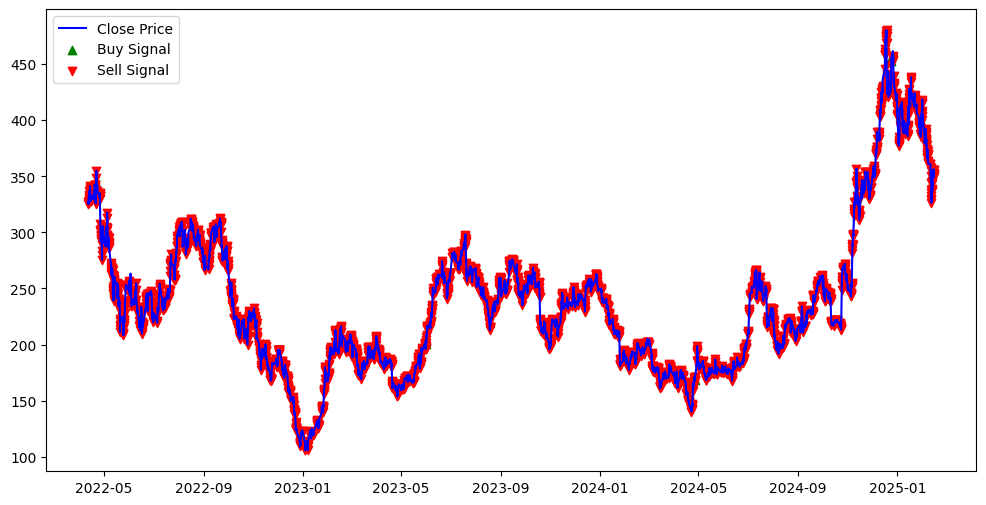

In [ ]:
# ✅ Plot Buy/Sell Signals
plt.figure(figsize=(12,6))
plt.plot(df['Datetime'], df['Close'], label='Close Price', color='blue')
plt.scatter(df[df['Buy_Signal']]['Datetime'], df[df['Buy_Signal']]['Close'], marker='^', color='green', label='Buy Signal')
plt.scatter(df[df['Sell_Signal']]['Datetime'], df[df['Sell_Signal']]['Close'], marker='v', color='red', label='Sell Signal')
plt.legend()
plt.show()

In [ ]:
# ✅ Initialize capital and trade log
capital = initial_balance
shares = 0
trade_log = []
STOP_LOSS_PERCENT = 0.90  # Stop-Loss at 10% drop
TAKE_PROFIT_PERCENT = 1.05  # Take-Profit at 10% gain
buy_price = None
last_trade_index = -5  # To prevent overtrading

for i in range(len(df)):
    price = df['Close'].iloc[i]

    # ✅ Buy Logic
    if df['Buy_Signal'].iloc[i] and (i - last_trade_index) > 3 and capital >= price * 10:
        buy_price = price
        shares = capital // price
        capital -= shares * price
        trade_log.append(f"BUY at {price:.2f}")
        last_trade_index = i

    # ✅ Sell Logic (Correctly Indented Inside the Loop)
    elif shares > 0:
        if df['Sell_Signal'].iloc[i] and price > buy_price * 1.01:  # Sell only if at least 1% profit
            capital += shares * price
            shares = 0
            trade_log.append(f"SELL (Manual Exit) at {price:.2f}")
        elif price >= buy_price * TAKE_PROFIT_PERCENT:
            capital += shares * price
            shares = 0
            trade_log.append(f"SELL (Take-Profit) at {price:.2f}")
        elif price <= buy_price * STOP_LOSS_PERCENT:
            capital += shares * price
            shares = 0
            trade_log.append(f"SELL (Stop-Loss) at {price:.2f}")

# ✅ Final Sell If Holding Any Shares
if shares > 0:
    capital += shares * df['Close'].iloc[-1]
    trade_log.append(f"FINAL SELL at {df['Close'].iloc[-1]:.2f}")

# ✅ Compute Performance Metrics
profit_trades = sum([1 for i in range(1, len(trade_log), 2) if float(trade_log[i].split(" at ")[1]) > float(trade_log[i-1].split(" at ")[1])])
total_trades = len(trade_log) // 2
win_rate = (profit_trades / total_trades) * 100 if total_trades > 0 else 0

# ✅ Print Final Performance
print(f"Final Portfolio Value: ${capital:.2f}")
print(f"Profit/Loss: ${capital - initial_balance:.2f}")
print(f"New Win Rate: {win_rate:.2f}%")
print(f"Trade Log: {trade_log}")


Final Portfolio Value: $11485.39
Profit/Loss: $1485.39
New Win Rate: 92.31%
Trade Log: ['BUY at 336.36', 'SELL (Stop-Loss) at 302.50', 'BUY at 239.40', 'SELL (Manual Exit) at 247.35', 'BUY at 220.42', 'SELL (Manual Exit) at 227.22', 'BUY at 224.89', 'SELL (Manual Exit) at 228.01', 'BUY at 200.50', 'SELL (Manual Exit) at 203.93', 'BUY at 204.04', 'SELL (Manual Exit) at 206.94', 'BUY at 255.94', 'SELL (Manual Exit) at 260.06', 'BUY at 221.97', 'SELL (Manual Exit) at 224.86', 'BUY at 168.40', 'SELL (Manual Exit) at 170.67', 'BUY at 174.73', 'SELL (Manual Exit) at 177.87', 'BUY at 176.17', 'SELL (Manual Exit) at 181.65', 'BUY at 181.97', 'SELL (Manual Exit) at 188.42', 'BUY at 452.68', 'SELL (Manual Exit) at 457.56']


In [ ]:
print(f"Total Buy Signals: {df['Buy_Signal'].sum()}")
print(f"Total Sell Signals: {df['Sell_Signal'].sum()}")


Total Buy Signals: 26
Total Sell Signals: 4414


In [ ]:
print("Sell Signals in Data:", df['Sell_Signal'].sum())
print("Total Sell Transactions in Trade Log:", sum(1 for trade in trade_log if "SELL" in trade))


Sell Signals in Data: 4414
Total Sell Transactions in Trade Log: 13
